# HomeWork 13

**DeadLine : 23:59 4 Day 1399**

**Total points : 100pts**

Import some prerequisites:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from keras.optimizers import SGD
from tensorflow import keras

Run this cell for plotting.

In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

Run this cell for plotting evaluation.

In [3]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


def evaluation(y_test, y_pred, fig_name, title):
    '''
    Prints accuracy and F1-score and plots confusion matrix and saves result image.

    Parameters:
        y_test (numpy.ndarray) : test labels (ground truth)
        y_pred (numpy.ndarray) : predicted labels 
        fig_name (str): The name of the image of the plot.
        title (str): The caption of the plot.
    '''

    acc = accuracy_score(y_test, y_pred)
    print('Accuracy for', title, '=', acc)
    f1 = f1_score(y_test, y_pred, average = 'macro')
    print('F1 score for', title, '=', f1)
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, range(10), range(10))
    plt.figure(figsize = (10, 7))
    sn.set(font_scale = 1.4) # for label size
    sn.heatmap(df_cm , annot = True, annot_kws = {"size" : 16}, fmt = 'g') # font size
    plt.title(title)
    plt.savefig(fig_name + '.png')
    plt.show()

Here is for your helper functions(optional)

Getting the data:

In [4]:
from keras.datasets import fashion_mnist

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

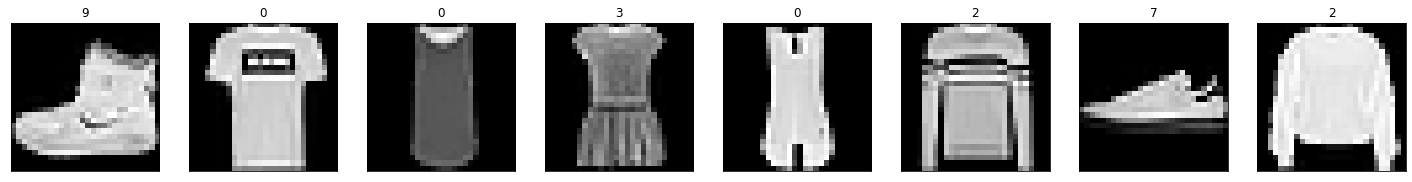

In [5]:
# show dataset
plt.figure(figsize=(25,4))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(y_train[i])

In [6]:
# Convert class vectors to binary class matrices.
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.reshape((x_train.shape[0] ,28 ,28 ,1))
x_test = x_test.reshape((x_test.shape[0] ,28 ,28 ,1))
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255

Create your model.

In [21]:
# define model
# model = keras.Sequential()
# model.add(keras.layers.Input(shape=x_train[0].shape))
# model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
# model.add(keras.layers.MaxPool2D())
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(units=100, activation='relu'))
# model.add(keras.layers.Dense(num_classes, activation='softmax'))

# Inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = keras.layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = keras.layers.Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = keras.layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = keras.layers.Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = keras.layers.Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = keras.layers.Concatenate(axis=-1)([conv1, conv3, conv5, pool])

    return layer_out

input = keras.layers.Input(shape=x_train[0].shape)
# add inception block 
layers = inception_module(input, 64, 96, 128, 16, 32, 32)
# add another inception block 
layers = inception_module(layers, 128, 128, 192, 32, 96, 64)

flatten = keras.layers.Flatten()(layers)
dense = keras.layers.Dense(units=100, activation='relu')(flatten)
dense = keras.layers.Dense(num_classes, activation='softmax')(dense)

model = keras.models.Model(inputs=input, outputs=dense)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 28, 28, 96)   192         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 28, 28, 16)   32          input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 28, 28, 1)    0           input_6[0][0]                    
____________________________________________________________________________________________

Train your model.

In [22]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
history = model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/10
600/600 [==============================] - 49s 79ms/step - loss: 0.6355 - accuracy: 0.8020 - val_loss: 0.2888 - val_accuracy: 0.8930
Epoch 2/10
600/600 [==============================] - 48s 81ms/step - loss: 0.2266 - accuracy: 0.9161 - val_loss: 0.2384 - val_accuracy: 0.9150
Epoch 3/10
600/600 [==============================] - 49s 82ms/step - loss: 0.1551 - accuracy: 0.9418 - val_loss: 0.2432 - val_accuracy: 0.9151
Epoch 4/10
600/600 [==============================] - 50s 83ms/step - loss: 0.1029 - accuracy: 0.9626 - val_loss: 0.2408 - val_accuracy: 0.9201
Epoch 5/10
600/600 [==============================] - 50s 83ms/step - loss: 0.0656 - accuracy: 0.9768 - val_loss: 0.2884 - val_accuracy: 0.9200
Epoch 6/10
600/600 [==============================] - 50s 84ms/step - loss: 0.0414 - accuracy: 0.9853 - val_loss: 0.3403 - val_accuracy: 0.9169
Epoch 7/10
600/600 [==============================] - 50s 84ms/step - loss: 0.0266 - accuracy: 0.9910 - val_loss: 0.3782 - val_accuracy:

Evaluate your model

[[859   2  18  18   4   1  92   0   6   0]
 [  2 979   1  12   3   0   3   0   0   0]
 [ 17   2 846  11  53   0  69   0   2   0]
 [ 14   2   8 932  20   0  23   0   1   0]
 [  2   1  35  20 884   0  57   0   1   0]
 [  0   0   0   0   0 985   0   7   0   8]
 [ 92   1  44  31  48   0 778   0   6   0]
 [  0   0   0   0   0   3   0 983   0  14]
 [  2   2   2   3   1   0   7   5 978   0]
 [  0   0   0   0   0   5   1  35   0 959]]
[[0.859 0.002 0.018 0.018 0.004 0.001 0.092 0.    0.006 0.   ]
 [0.002 0.979 0.001 0.012 0.003 0.    0.003 0.    0.    0.   ]
 [0.017 0.002 0.846 0.011 0.053 0.    0.069 0.    0.002 0.   ]
 [0.014 0.002 0.008 0.932 0.02  0.    0.023 0.    0.001 0.   ]
 [0.002 0.001 0.035 0.02  0.884 0.    0.057 0.    0.001 0.   ]
 [0.    0.    0.    0.    0.    0.985 0.    0.007 0.    0.008]
 [0.092 0.001 0.044 0.031 0.048 0.    0.778 0.    0.006 0.   ]
 [0.    0.    0.    0.    0.    0.003 0.    0.983 0.    0.014]
 [0.002 0.002 0.002 0.003 0.001 0.    0.007 0.005 0.978 0.   ]
 [

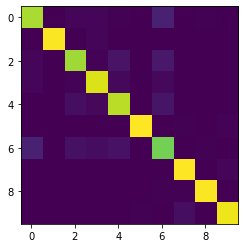

In [23]:
# Suggestion: Using the evaluation function.
# Get y_pred for y_test from model.predict() then use evaluation(y_test, y_pred, fig_name, title)
# with proper name for fig_name and title.
# plot confusion matrix
import sklearn.metrics

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize=None)

plt.imshow(conf)
print(conf)

conf_norm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='true')
print(np.round(conf_norm, 3))


Show 10 bad loss images.

test label: 0 -> prediction label: 3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


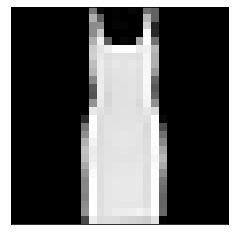

test label: 3 -> prediction label: 6
[0.179 0.    0.    0.    0.    0.    0.821 0.    0.    0.   ]


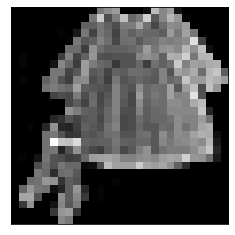

test label: 6 -> prediction label: 3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


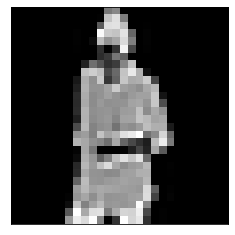

test label: 2 -> prediction label: 3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


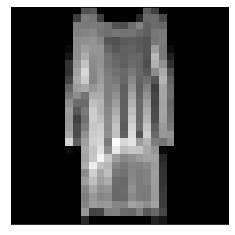

test label: 0 -> prediction label: 3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


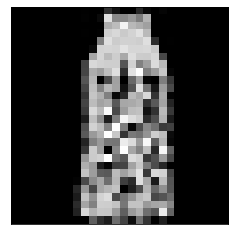

test label: 2 -> prediction label: 1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


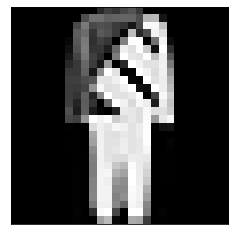

test label: 3 -> prediction label: 6
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


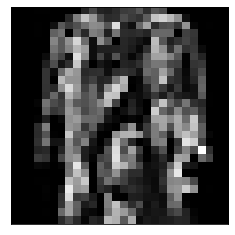

test label: 3 -> prediction label: 0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


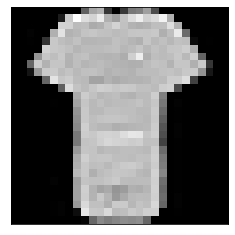

test label: 4 -> prediction label: 3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


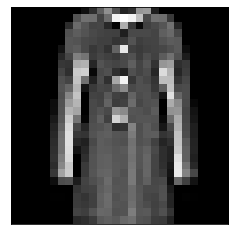

test label: 6 -> prediction label: 0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


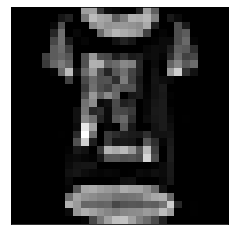

In [72]:
# Suggestion: Using the plotter function.
y_pred = model.predict(x_test)
idx = np.where(np.argmax(y_pred, axis=1) != np.argmax(y_test, axis=1))[0]
errors = []
for i in idx:
    index = np.argmax(y_test[i])
    errors.append((y_pred[i][index], i))

for i in range(10):
    worse_res = min(errors, key = lambda j : j[0])
    print('test label: {} -> prediction label: {}'.format(np.argmax(y_test[worse_res[1]]), np.argmax(y_pred[worse_res[1]])))
    print(np.round(y_pred[worse_res[1]], 3))
    plt.figure()
    plt.imshow(x_test[worse_res[1], ..., 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    errors.remove(worse_res)

End!!!